In [1]:

#%%
import torch

args = {
    'epoch_num': 100,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'batch_size': 2,     # Mini-batch size. 600
    'batch_test': 2,     # size of test batch
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

dataset_name = "PAMAP2"

#"OurConvLSTM", "AttentionTransformer", "DeepConvLSTM", "CnnIMU"

plot_subject = 2




! pip install wget
import os
import torch
import pandas as pd
import numpy as np
import torch
from torch import nn


ssh_config = """
Host github.com
  IdentityFile ~/.ssh/github.pem
  User davipeag
  StrictHostKeyChecking no
"""

if os.name == 'nt':
  base_path = ""
  REPO_DIR = "."
  STORE_DIR ="." 
  print("Windows")
else:
  print("Unix-like")
  REPO_DIR = "/tmp/HeartRateRegression"
  from google.colab import drive
  drive.mount('/content/drive')
  GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
  DATA_PATH = "/content/drive/My\ Drive/deeplearning_project/normalized.zip"
  STORE_DIR ="/content/drive/My Drive/deeplearning_project/" 
  !mkdir ~/.ssh
  !cp -u {GIT_PATH} ~/.ssh/
  !chmod u=rw,g=,o= ~/.ssh/github.pem
  !echo "{ssh_config}" > ~/.ssh/config
  !chmod u=rw,g=,o= ~/.ssh/config
  ! (cd /tmp && git clone git@github.com:davipeag/HeartRateRegression.git)
  ! (cd {REPO_DIR} && git pull )
  import sys
  sys.path.append(REPO_DIR)



def git_push():
  if os.name == 'nt':
    pass
  else:
    ! git config --global user.email "daviaguiar@outlook.com"
    ! git config --global user.name "Davi Pedrosa de Aguiar"
    print("going to push")
    ! (cd {REPO_DIR} && git pull && cd -)
    ! (cd {REPO_DIR} && git add . && git commit -m "from colab" && git push)

def git_pull():
  if os.name == 'nt':
    pass
  else:
    ! git config --global user.email "daviaguiar@outlook.com"
    ! git config --global user.name "Davi Pedrosa de Aguiar"
    print("going to push")
    ! (cd {REPO_DIR} && git pull && cd -)
    
  
git_push()



from data_utils import (
    Pamap2Handler, cross_validation_split)

from default_utils import DefaultPamapPreprocessing
from preprocessing_utils import (OurConvLstmToAttentionFormat, OurConvLstmToCnnImuFormat)

from models_utils import OurConvLstmDataset, make_loader, reset_seeds
from models_utils import DatasetXY

from default_utils import TrainOurConvLSTM, TrainXY
from default_utils import make_our_conv_lstm, make_attention_transormer_model 
from torch import nn



reset_seeds()


#%%

dataset_handler = Pamap2Handler(os.path.join(REPO_DIR, ".."))

dfs = [dataset_handler.get_protocol_subject(s) for s in [1,2,3,4,5,6,7,8]]
df_full = pd.concat(dfs)

#%%


cuda
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=8b493320b19597454118a78e255eb8378fde80bbd3a03809cc471b99d77519f9
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Unix-like
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Cloning into 'HeartRateRegression'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (172/172), don

In [2]:
#dfs = [dfs[plot_subject]]

In [5]:
models = ["OurConvLSTM", "DeepConvLSTM", "FCNN", "CnnIMU"]

is_size = 2 
recursive_size = 800
total_size = recursive_size + is_size


from default_utils import FcPamapPreprocessing, make_fcnn

preprocessing_options = {
    "OurConvLSTM": DefaultPamapPreprocessing(ts_per_sample=total_size, ts_count = 300, donwsampling_ratio = 1),
    "AttentionTransformer": DefaultPamapPreprocessing(ts_per_sample=total_size, last_transformer=OurConvLstmToAttentionFormat()),
    "DeepConvLSTM": DefaultPamapPreprocessing(ts_per_sample=total_size, last_transformer=OurConvLstmToCnnImuFormat()),
    "CnnIMU": DefaultPamapPreprocessing(ts_per_sample=total_size, last_transformer=OurConvLstmToCnnImuFormat()),
    "FCNN": FcPamapPreprocessing(ts_per_sample=total_size),
 }



preprocessors =[preprocessing_options[model] for model in models]
tdata = list()
for preprocessor in preprocessors:
    preprocessor.transformers.fit(df_full)
    tdata.append(preprocessor.transformers.transform(dfs[plot_subject]))

# del dfs
# del df_full

dataset_cls_options = {
    "OurConvLSTM": OurConvLstmDataset,
    "AttentionTransformer": DatasetXY,
    "DeepConvLSTM": DatasetXY,
    "CnnIMU": DatasetXY,
    "FCNN": DatasetXY,
 }


datasets_cls = [dataset_cls_options[model_type] for model_type in models]

loaders = [make_loader([xy], dataset_cls, batch_size = args["batch_size"], shuffle=False)
            for dataset_cls, xy in zip(datasets_cls, tdata)]


from default_utils import make_cnn_imu2
from default_utils import make_deep_conv_lstm


net_options = {
    "OurConvLSTM": lambda : make_our_conv_lstm(40,1),
    "AttentionTransformer": lambda: make_attention_transormer_model(args["device"]),
    "DeepConvLSTM": lambda : make_deep_conv_lstm(recursive_size=recursive_size, total_size=total_size),
    "CnnIMU": lambda : make_cnn_imu2(recursive_size=recursive_size, total_size=total_size),
    "FCNN": lambda : make_fcnn()
}

nets = [net_options[model_type]().to(args["device"]) for model_type in models]

#net = net_options[model_type]().to(args["device"])
criterion = nn.L1Loss().to(args["device"]) 



OurConvLSTM
DeepConvLSTM


FileNotFoundError: ignored

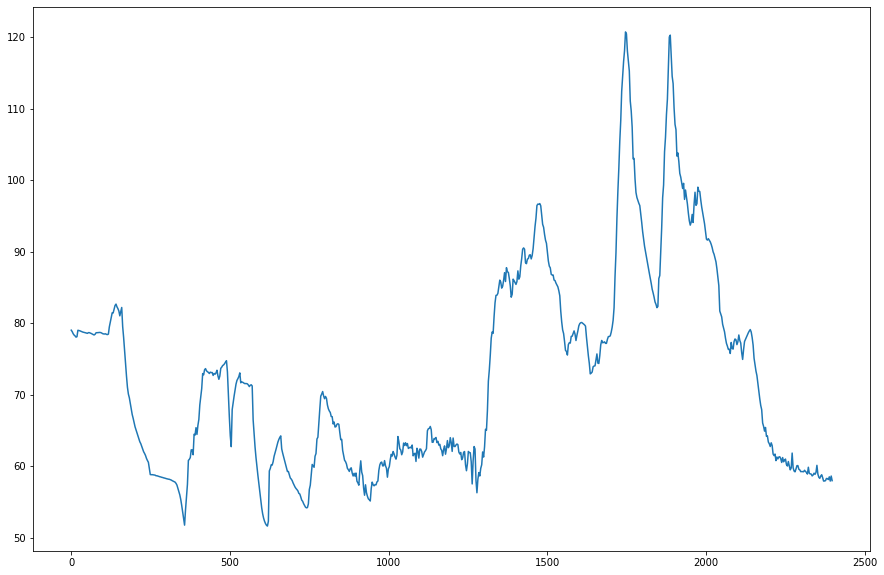

In [6]:
trainers = list()

for preprocessor,net, model_type in zip(preprocessors,nets, models):

    optimizer = torch.optim.Adam(net.parameters(), lr=args["lr"],
                             weight_decay=args["weight_decay"])

    basic_training_parameters = {
        "net": net,
        "criterion": criterion,
        "optimizer": optimizer,
        "loader_tr": None,
        "loader_val": None,
        "loader_ts": None,
        "normdz": preprocessor.normdz,
        "ztransformer": preprocessor.ztransformer,
        "device": args["device"]
    }


    trainer_options = {
        "OurConvLSTM": lambda : TrainOurConvLSTM(**basic_training_parameters),
        "AttentionTransformer": lambda : TrainXY(
            **basic_training_parameters,
            get_last_y_from_x = lambda x: x[:,1, 0, -1].reshape(-1,1)
        ),
        "CnnIMU":lambda : TrainXY(
            **basic_training_parameters,
            get_last_y_from_x = lambda x: np.mean(x[:,0,100:200, 0], axis=1).reshape(-1,1)
        ),
        "DeepConvLSTM":lambda : TrainXY(
            **basic_training_parameters,
            get_last_y_from_x = lambda x: np.mean(x[:,0,100:200, 0], axis=1).reshape(-1,1)
        ),
        "FCNN":lambda : TrainXY(
            **basic_training_parameters,
            get_last_y_from_x = lambda x: x[:,0, 0].reshape(-1,1)
        ),

        
         

    }

    trainer = trainer_options[model_type]()
    trainers.append(trainer)

import os
import matplotlib.pyplot as plt
figures = list()
for idx in range(1):
  fig, ax = plt.subplots(figsize=(15,10))
  figures.append((fig, ax))
  for model_type, loader, trainer in list(zip(models, loaders, trainers))[0:]:
      print(model_type)
      state_dict_name = f"trained_models/{model_type}ts_{plot_subject}_val_{3}.pkl"
      state_dict_path = os.path.join(STORE_DIR, state_dict_name)
      trainer.net.load_state_dict(torch.load(state_dict_path, map_location=args["device"]))
      y,p = trainer.reverse_transformed_prediction_labels(loader)
      ax.plot(np.linspace(0, 3*(len(p[idx])-1), len(p[idx])), p[idx], label=model_type)
  ax.plot(np.linspace(0, 3*(len(p[idx])-1), len(p[idx])), y[idx], 'k', label="actual")
  ax.set_ylabel("heart rate [beats per minute]")
  ax.set_xlabel("time[seconds]")
  ax.legend()
  fig.show()


In [ ]:
fig,ax = figures[0]

fig.savefig(os.path.join(STORE_DIR, "sample_2_long_period.jpg"))


In [ ]:
STORE_DIR ="/content/drive/My Drive/deeplearning_project/" 